# ASG7:
This notebook contains the submission materials for Ian Feekes' submission of Module 7 USD MSAAI Machine Learning fundamentals class. 

If the material in this submission does not meet requirements, please email me at ifeekes@sandiego.edu and I will gratefully and expediently remedy the situation. 

The material for this code should live in the repository here: https://github.com/USD-AAI/aai-510-01-su22-new-ianfeekes-sandiego/tree/main/Module_7

Thank you for taking the time to teach me and to evaluate my work!

## Prompt:
Hidden Markov models have gained popularity for time series and longitudinal data in recent years due to a combination of (relative) simplicity and flexibility in adapting the model to novel situations.

The objective of this exercise is to identify the time-series component of this data set and use it to improve the predictive performance of your Gradient Boosted Model from Module 4.

Pick one or more data files from the Home Credit Default Risk data to build a HMM model. 
###### Provide 3 reason(s) for using that data file.
Build the HMM model from the data file and use it to 
###### improve the performance of the Gradient Boosted Tree (GBT) model from Module 4.
Chart the impact of adding the HMM model to the mix. 
###### Theorize on why you observe the results obtained.

## Analysis: 

##### Data File:
The data file I selected for constructing the HMM is bureau_balance.csv. The file details previous loan statuses for a subset of users in previous loan payments. This is categorized into 8 various states, which the HMM aggregates into 4 (performing, modified, non-performing, default). The un-treated state for "default" of which we are particularly interested in, is set to 4. The main reasons for selecting bureau_balance.csv are:

1) Powerful: 

bureau_balance.csv has a very robust amount of observations and number of unique users. The file is same size as credit_card_balance.csv while only containing 3 columns (and 2.7 million entries). Having a larger time-series (averaging 12 observations per variable), is very desirable when generating a HMM. This allows us to know that the underlying model is trained on long Markov chains and is minimally subject to poor-fitting. 

2) Time-series component intuitively correlated with target:

Loan statuses are categorized into states that can be directly translated to HMM states. These statuses include a defaulting state, and several non-performing states in increasing severity with respect to time. There are over 62,000 occurrences of defaulting, and many more of non-performing payment states of which we can clean some significant insight towards a Target variable which, in the training data set, has a very poor distribution

3) Clean Data, simple:


Bureau_balance.csv contains previous loan status for users in a pre-sorted time series. There are no duplicate timestamps for any given ID nor missing values, bad types, etc. The file minimizes dimensionality, and the obscurity associate with it.

Additionally, models trained with bureau_balanced could be further leveraged from bureau.csv data, if desired. 

##### Performance:
The baseline performance for the GBT from assignment 4 was:

Accuracy: 0.16609811967590615 

Precision 0.09952045046202843

With the HMM, the performance for the GBT is brought up to

Accuracy: 0.19504214005120314 

Precision 0.14088785098524390


This shows a 3% improvement in performance to the GBT with use of the HMM on previous loan balance data.

##### Theorize Results
This improvement in performance is due to the addition of a previous, time-based feature to the dataset which has a high correlation to the target variable. This intuitively makes sense as the utilization of time-based data in correlation with the present rings true with payments: one who has defaulted on loans in the past is more likely to default on loans in the future, and this is something that isn't necessarily captured in the training dataset. Predicting status from a series of payments in a previous loan adds quite a lot of value, without cursing the dimensionality with something that is particularly correlated with other features extracted by the GBT. 

This shows that the Markov Model is a powerful tool for utilizing time-based data and series of observations into a useful parameter for machine learning models.

#### References:
http://scikit-learn.sourceforge.net/stable/modules/hmm.html

https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.944.9873&rep=rep1&type=pdf

https://hmmlearn.readthedocs.io/en/latest/tutorial.html#multiple-sequences

https://run.unl.pt/bitstream/10362/63689/1/TEGI0435.pdf

http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017

[Rabiner89] A tutorial on hidden Markov models and selected applications in speech recognition Lawrence, R. Rabiner, 1989

### Global Variables
The following cell contains files used for directory organization, global flags, and other useful files

In [35]:
# Global Variables
debug = True                        # Displays additional logging output
savePlots = False                   # Saves plot image files
showCorrelation = False             # Saves information on correlation variablespca = PCA(10)
targetColumnName = "TARGET"         # Name for column denoting dependant variable
outlierThreshold = 3                # Number of standard deviations from which data will be classified as an outlier
dropMissingValues = True            #Needs to be true for randomTreeRegressor
plotAllVariables = False            # Plot boxplots and bar plots for the entire dataset - time consuming

# Used for debugging display
lineString = "---------------------------------------------------------------------------------------------------------"

if debug == True:
    print("Global variables cell completed...")

Global variables cell completed...


### Library Inports
The following cell contains various library imports used largely for data frames, data analysis, and plotting. 

In [36]:
# Library Imports
from nis import cat
from re import X
import pandas as pd                 # Used for data frame
import plotly                       # Saves html plots
import plotly.express as px         # Used for displaying plots
import os                           # Allows file manipulation and console debugging for offline jupyter
import numpy as np
from scipy import stats             # Used for outliers
import matplotlib.pyplot as plt     # Used for pyplot heatmap plotting
import seaborn as sns               # Used for showing heatmap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
    # Import the model we are using
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.ensemble import RandomForestRegressor
#@TODO: Figure out if we want to delete this or not and use the sklearn tree
from sklearn import tree
from sklearn.datasets import load_iris
import graphviz # Data Tree Visualization

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
import pickle                                   # Saving Models
from sklearn.ensemble import RandomForestClassifier

import graphviz # Data Tree Visualization
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
import pydot

import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

if debug == True:
    print("Library Imports Cell Completed...")

Library Imports Cell Completed...


### Helper Functions
The below cell contains various helper functions, which have descriptions of annotations in their headers

In [37]:
# Helper Functions

# Reads csv file into data frame and sets independant and dependant variables
#
# Parameters:
# -----------
# @param fileName: string for full relative file path of csv file
# @param dependantVarColumnName: csv file column matching name of column for dependant variable
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# data: dataframe object of csv file reading
# independantVars: independant variables (all data that isn't targetColumnName)
# dependantVar: dependant variable
#
def readData(fileName, dependantVarColumnName = targetColumnName, debug = False):
    independantVars = []
    dependantVar = []
    data = pd.read_csv(fileName)
    index = None
    for i ,col in enumerate(data.columns):
        if col == dependantVarColumnName:
            index = i
    if index != None: 
        dependantVar = data.iloc[:, index]
        independantVars = data.iloc[:]
        independantVars.pop(dependantVarColumnName)
    if debug:
        print("readData...completed")
    return data, independantVars, dependantVar

# Plots bar plots
def doBar(data, column_name, figsize = (18,6), 
          percentage_display = True,
          plot_defaulter = True, rotation = 0, 
          horizontal_adjust = 0, 
          fontsize_percent = 'xx-small',
          dirName = 'images/initialPlots/'):

    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter and targetColumnName in data.columns:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)

# Plots a column name of the dataframe and saves each plot into a file
#
# Parameters:
# -----------
# @param data:       dataframe to have distribution written to text file
# @param plots:      types of plots for each column to show e.g. "box"
# @param: figsize:   size of figure for matplotlib to plot
# @param: log_scale: flag to log the scale of the plot
#
# Returns:
# ---------
# None
#
def plot_column(data,
                column_name,
                plots = [],
                figsize = (20,8),
                log_scale = False,
                dirName = 'images/initialPlots/'):

    if 'bar' in plots:
        doBar(data, column_name, figsize, dirName = dirName)
        return
    data_to_plot = data.copy()
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, len(plots), i + 1)
        plt.subplots_adjust(wspace=0.25)
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
        elif ele == 'distplot':
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')
        elif ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')
        elif ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    
# Plots distribution of TARGET variable
#
# Parameters:
# -----------
# @param data:   dataframe used for heatmap display
# @param debug:  optional flag for debugging
#
# Returns
# ---------
# None
#
def showTargetPlot(data, debug = False):
    class_dist = data[targetColumnName].value_counts()
    # Plots a Bar chart
    plt.figure(figsize=(12,3))
    plt.title('Distribution of TARGET variable')
    plt.barh(class_dist.index, class_dist.values)
    plt.yticks([0, 1])
    for i, value in enumerate(class_dist.values):
        plt.text(value-2000, i, str(value), fontsize=12, color='white',
                 horizontalalignment='right', verticalalignment='center')
    plt.show()
    # Or if you like pie more
    fig, ax1 = plt.subplots()
    ax1.pie(class_dist.values, labels = ["Successfully Paid off Loan", "Defaulted"])
    ax1.axis('equal')
    ax1.title.set_text("Pie Chart of Target Variable Frequencies")
    plt.show()

    
# Shows heatmap of all variables in data frame argument
#
# Parameters:
# -----------
# @param data:   dataframe used for heatmap display
#
# Returns
# ---------
# None
#
def showHeatmap(data):
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    plt.title("Heatmap of all Variables")
    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(),cmap="RdYlGn")
    plt.show()


# Drops variables in a list from data frame and returns clipped data frame
#
# Parameters:
# -----------
# @param variables:   [list] List of column names to drop from data frame
# @param dataFrame:   [df]   Data Frame from which to drop the variables
#
# Returns
# ---------
# Ret: Copy of data frame with variables dropped
#
def dropVariables(variables, dataFrame):
    # Create return data frame
    ret = dataFrame.copy()
    # Variables used to determine success of dropping meaningless variables in cell
    notDroppedYet = False
    for i in variables:
        if i in dataFrame.columns:
            notDroppedYet = True
    originalColumnNum = dataFrame.shape[0]                                      
    # Verify something has been dropped and output for debug use
    if notDroppedYet:
        try:
            # Remove any existing columns from our data frame
            for i in variables:
                if i in ret.columns:
                    ret.drop(i, axis = 1, inplace = True)
            assert(ret.shape[1] < originalColumnNum)
            if debug == True:
                print("Successfully dropped", originalColumnNum - ret.shape[0],"meaningless variables")
        except:
            if debug == True:
                print("Error: failed to drop columns when a column was initially present in the data frame")
    elif debug == True:
        print("Meaningless variables already removed...skipping step")
    # Return dataframe with dropped variables, or unmodified
    return ret


# Gets columns present in data frame
def columnsInDataFrame(variables, dataFrame):
    ret = []
    for i in variables:
        if i in dataFrame.columns:
            ret.append(i)
    return ret

if debug == True:
    print("Helper functions successfully imported")

Helper functions successfully imported


## Read Data

### Reading Training Data

In [38]:
# Read the data, assigning independant and dependant variables
data, x, y = readData('./dataset/application_train.csv', targetColumnName, debug)

readData...completed


## Data Cleaning

In [39]:
def setAllNaN(df, badStringList = ['XNA', 'Other', 'Unknown']):
    ret = df.copy()
    for i in ret.columns:
        # Find current number of NaN columns
        numNan = ret.isnull().sum()[i]
        for badString in badStringList:
            ret[i] = np.where(ret[i] == badString, np.NaN, ret[i])
        # Only display entries deleted for variables that have been manipulated
        if debug == True and ret.isnull().sum()[i]-numNan > 0:
            print(ret.isnull().sum()[i]-numNan,"entries deleted for",i)
    # Verify before returning:
    for i in ret.columns:
        for entry in ret[i]:
            try:
                assert(not(entry in badStringList))
            except:
                if debug == True:
                    print("setAllNaN: Error: bad string remained in data frame after removing: ", entry)
                return False
    return ret

def splitTypes(df, ordinalColumns):
    # Start with categorical:
    
    # Assume all string columns are categorical prior to encoding
    categorical = df.select_dtypes(include = 'object')
    # Get the columns that are actually in the data frame
    ordinal = columnsInDataFrame(ordinalColumns, df)
    # Don't duplicate any categorical columns, build our categorical data frame
    for col in ordinal:
        if col not in categorical.columns:
            categorical = categorical.join(df[col])
    # Add target column for plotting purposes if it's part of the data frame
    if targetColumnName not in categorical.columns and targetColumnName in df.columns:
        categorical = categorical.join(df[targetColumnName])
        # Break if we are working with target column and it fails to get added to categorical
        try:
            assert(targetColumnName in categorical.columns)
        except:
            if debug == True:
                print("splitTypes: error:",targetColumnName,"not in ",categorical.columns)
            return False, False
        
    # Now for continuous it will be remainder, make sure to add target if desired:
    continuous = df.drop(categorical, axis=1)
    if targetColumnName not in continuous.columns and targetColumnName in df.columns:
        continuous = continuous.join(df[targetColumnName])
        # Break if we are working with target column and it fails to get added to continuous
        try:
            assert(targetColumnName in continuous.columns)
        except:
            if  debug == True:
                print("splitTypes: error:",targetColumnName,"not in", continuous.columns)
            return False, False
    
    # Print success message if debugging
    if debug == True:
        print("splitTypes: types successfully split. Returning...")
    # Return our categorical and continuous
    return categorical, continuous


def getCategoricalDummies(df, excludeList = ['TARGET']):
    if debug == True:
        print("getCategoricalDummies: encoding categorical variables")
    # Copy data frame which will be returned
    ret = df.copy()
    # Shape should not be changing
    prevShape = df.shape
    # Determine columns that are not blacklisted
    tempColumns = []
    for i in df.columns:
        if i not in excludeList:
            tempColumns.append(i)
    # Don't do anything if we've already encoded
    if len(tempColumns) < 1:
        return ret
    # Iterate through desired columns, convert to binary, retain dimensionality
    for i in tempColumns:
        # This branch should probably never be executed
        if i not in ret.columns: 
            continue
        # One-hot-encode current column
        dummies = pd.get_dummies(ret[i], drop_first = True)
        # Do this for all categories
        for j in dummies.columns:
            # Give it name of "<original_variable_name>_<category>" and ignore floating point decimals
            colName = i+"_"+str(j).split('.')[0]
            # Replace old with new
            ret[colName] = dummies[j]
        ret.drop(i, axis = 1, inplace = True)
    return ret

def setDays(df, mappings):
    # Create return object
    ret = df.copy()
    # Iterate through mappings and create new columns
    for key, val in mappings.items():
        # Ignore mappings that aren't in data frame or have been done already
        if key not in ret.columns or val in ret.columns: continue
        # Copy column as positive year value and append it to data frame
        newCol = round(abs(df[key]) / (365))
        ret.insert(len(ret.columns), val, newCol.values)
        ret.drop(key, axis = 1, inplace = True)
        # Break the code if the desired mapping has not been followed
        try:
            assert(val in ret.columns)
            assert(key not in ret.columns)
        except:
            if debug == True:
                print("setDays: Error: Failure to add/drop column to data frame: key: ",key,"value:",val)
            return False
    # Return our new data frame
    return ret

# Copies dataframe column, sets outlier values to limits and returns
def windsorizeColumn(df):
    newCol = df.copy()
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    iqr=q3-q1
    for idx, val in enumerate(newCol):
        if val < (q1 - 1.5 * iqr):
            newCol[idx] = q1 - 1.5 * iqr
        elif val > (q3 + 1.5 * iqr):
            newCol[idx] = q3 + 1.5 * iqr
    return newCol

#
# Description:
# ------------
# Copies data frame, removes columns in variablesToDrop list, 
# splits categorical and continuous types,verifies no duplicate entries are present in the data frame
#
# Deals with categorical variables as follows:
# 1) Sets bad/useless categories to NaN and fills them with modal category entries for respective variables
# 2) One-hot-encodes categorical variables
# 
# Deals with continuous variables as follows:
# 1) Converts days values to years
#
def cleanData(df, variablesToDrop = [], ordinalColumns = [], daysMapping = {}):
    # Copy data frame
    cleanData = df.copy()
    # Break if copy behaves strangely for some reason
    try:
        assert(len(cleanData.columns) > 0 and len(cleanData.columns) == len(df.columns))
    except:
        if debug == True:
            print("cleanData: Error: failure to copy dataframe parameter")
        return False
    # Remove any variables we have pre-selected as useless
    cleanData = dropVariables(variablesToDrop, cleanData)
    # Break if variables are in clean data frame after attempting to drop
    for i in variablesToDrop:
        try:
            assert(i not in cleanData.columns)
        except:
            if debug == True:
                print("cleanData: Error: column for requested deletion",i,"remains in data frame")
            return False
    # Show how many variables have been dropped so far, if desired
    if debug == True:
        print("cleanData:",df.shape[1] - cleanData.shape[1], "variables successfully dropped")
        # Breaks execution of code if there is a duplicate in the dataset which needs to be fixed
    for i in cleanData.duplicated():
        try:
            assert(i == False)
        except:
            if debug == True:
                print("cleanData: Error: duplicate value found: ",i)
            return False
    if debug == True:
        print("cleanData: successfully verified no duplicate values present")
    # Split the categorical and continuous columns for separate cleaning
    categorical, continuous = splitTypes(cleanData, ordinalColumns)
    # Make sure splitting is successful
    if not type(categorical) == pd.DataFrame or not type(continuous) == pd.DataFrame:
        if debug == True:
            print("cleanData: Error: bad return from splitting data. Categorical:",categorical,", Continuous:",continuous)
        return False
    elif debug == True:
        print("cleanData: successfullly split categorical and continuous columns")
    # Set Bad Categorical Values to NaN
    categorical = setAllNaN(categorical)
    if not type(categorical) == pd.DataFrame:
        if debug == True:
            print("cleanData: Error: failed to remove a bad entry from data frame")
        return False
    elif debug == True:
        print("cleanData: successfully set bad categorical entries to NaN")
    # Set nans to mode
    categorical = categorical.fillna(categorical.mode().iloc[0])
    # Break the code if the data frame has any null categorical entries
    try:
        assert(sum(categorical.isnull().sum()) == 0)
    except:
        if debug == True:
            print("cleanData: Error: null value in data frame after setting entries to mode")
        return False
    if debug == True:
        print("cleanData: successfully set null categorical entries to mode")
    # One hot encode our categorical data
    categorical = getCategoricalDummies(categorical)
    if not type(categorical) == pd.DataFrame:
        return False
    elif debug == True:
        print("cleanData: successfully encoded categorical variables")
    # Set up our days to years variables in a desired format
    continuous = setDays(continuous, daysMapping)    
    if not type(continuous) == pd.DataFrame:
        return False
    elif debug == True:
        print("cleanData: successfully set days")
    # Fill continuous values with mean for now
    continuous.fillna(continuous.mean())
    # Create our return object
    ret = continuous.copy()
    for i in categorical.columns:
        if i not in ret.columns:
            ret = ret.join(categorical[i])
    return ret
    

#### Declare Meaningless Continuous Variables
These are the continuous variables which have been selected for removal after several iterations of supervised analysis.

In [40]:
# Continuous columns we are interested in removing
meaninglessContinuousVariables = ['NONLIVINGAPARTMENTS_AVG',
                                  'NONLIVINGAPARTMENTS_MODE',
                                  'NONLIVINGAPARTMENTS_MEDI',
                                  'NONLIVINGAREA_AVG',
                                  'NONLIVINGAREA_MODE',
                                  'NONLIVINGAREA_MEDI',
                                  'HOUR_APPR_PROCESS_START',
                                  'YEARS_LAST_PHONE_CHANGE'] # Decided to remove in ASG4

#### Declaring Meaningless Categorical Variables
These are the categorical variables which have been selected for removal after several iterations of supervised analysis.

In [41]:
# Categorical columns we are interested in removing
meaninglessCategoricalVariables = [
    'EMERGENCYSTATE_MODE',
    'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21',
    'FLAG_EMAIL',
    'FLAG_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_WORK_PHONE',
    'HOUSETYPE_MODE',
    'WEEKDAY_APPR_PROCESS_START',
    'FLAG_MOBIL',
    'ORGANIZATION_TYPE'            # Decided to remove in ASG4
]

#### Setting Map for days to years variables
This is a map which will be a parameter of the cleanData function. The map's keys are variables present in the input data frame which will be converted to their respective values as positive values divided by 365. This is done for analytics readability and data abstraction.

In [42]:
# Declare Mapping list of days variables to look at and new names to give them
daysColumnsMapping = {'DAYS_BIRTH':             'YEARS_BIRTH',
                      'DAYS_EMPLOYED':          'YEARS_EMPLOYED',
                      'DAYS_REGISTRATION':      'YEARS_REGISTRATION',
                      'DAYS_ID_PUBLISH':        'YEARS_ID_PUBLISH'}

#### Set Desired Columns

In [43]:
desiredColList = ["TARGET","OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE","OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE","EXT_SOURCE_2","AMT_GOODS_PRICE","DAYS_LAST_PHONE_CHANGE","DAYS_BIRTH","DAYS_EMPLOYED","DAYS_REGISTRATION","AMT_ANNUITY","AMT_CREDIT","AMT_INCOME_TOTAL","REGION_POPULATION_RELATIVE","CNT_CHILDREN","CNT_FAM_MEMBERS","FLAG_MOBIL","FLAG_EMP_PHONE","FLAG_WORK_PHONE","FLAG_PHONE","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY"]
desiredColList = columnsInDataFrame(desiredColList, data)

dataColsRemoved = data[desiredColList]

#### Perform Data Cleaning Call

In [44]:
# Clean the data
data2 = cleanData(dataColsRemoved,
                  meaninglessContinuousVariables + meaninglessCategoricalVariables,
                  [],
                  daysColumnsMapping)

Successfully dropped 0 meaningless variables
cleanData: 3 variables successfully dropped
cleanData: successfully verified no duplicate values present
splitTypes: types successfully split. Returning...
cleanData: successfullly split categorical and continuous columns
4 entries deleted for CODE_GENDER
cleanData: successfully set bad categorical entries to NaN
cleanData: successfully set null categorical entries to mode
getCategoricalDummies: encoding categorical variables
cleanData: successfully encoded categorical variables
cleanData: successfully set days


### Exploring Cleaned Data

#### Describing Clean Data Columns

In [45]:
if debug == True:
    # Describe each of the columns in the clean data frame
    for i in data2.columns:
        print(data2[i].describe())
        print(lineString)
    # Describe number of variables as well
    print("Data Frame now has",data2.shape[1],"variables")

count    306490.000000
mean          1.422245
std           2.400989
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         348.000000
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64
---------------------------------------------------------------------------------------------------------
count    306490.000000
mean          0.143421
std           0.446698
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          34.000000
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64
---------------------------------------------------------------------------------------------------------
count    306490.000000
mean          1.405292
std           2.379803
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         344.000000
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64
-----------------------------------------------------------------------------------------------

#### Showing Heatmap of Cleaned Data
From the heatmap printed below we can see more strongly-pronounced correlations between various variables, along with some red spots denoted from categories that have been encoded. We can more easily visualize certain features in the data frame.

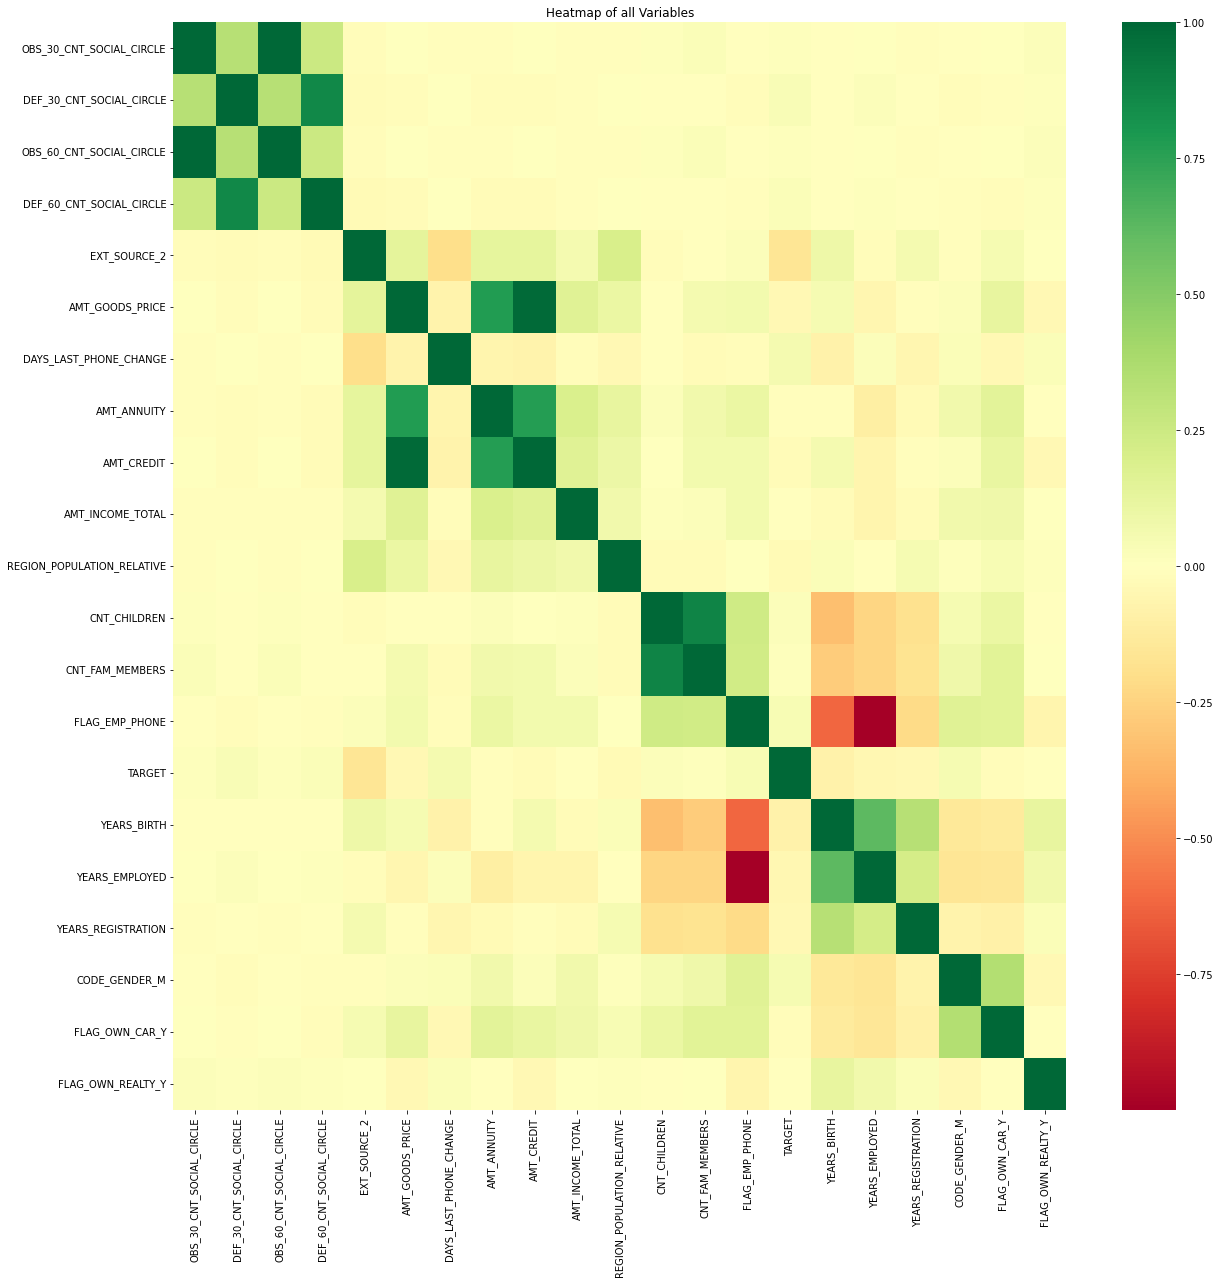

In [46]:
showHeatmap(data2)

#### Selecting Numeric Types from Training Data Frame

In [47]:
acceptableNumericTypes = [float, int]

# Get numeric data frame. Should already be numeric after cleaning
data2Numeric = data2.select_dtypes(include = ['float', 'int', 'uint8'])
# Verify we are working exclusively with numeric types
for i in data2Numeric:
    try:
        assert(data2Numeric[i].dtype in acceptableNumericTypes or data2Numeric[i].dtype == 'uint8')
    except:
        if debug == True:
            print("Error: non-numeric type in numeric data frame for column:",i)

if debug == True:
    print("Extracting numeric types from training data complete")

Extracting numeric types from training data complete


#### Verifying No Other Types exist

In [48]:
assert(len(data2.drop(data2Numeric.columns, axis = 1).columns) == 0)

if debug == True:
    print("No non-numeric columns exist in the training data frame")

No non-numeric columns exist in the training data frame


### Creating GBT
Here we use xgboost, which is responsible for about 80% of the top kaggle submissions, as our GBT model.

In [49]:
import xgboost as xgb

feature = data2.drop([targetColumnName], axis = 1).to_numpy()
label = data2[targetColumnName].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.33, random_state=42)

dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

if debug == True:
    print("Successfully created xgboost GBT")

Successfully created xgboost GBT


In [50]:
# Create parameters
param = {'max_depth':4, 'eta':1, 'objective':'binary:logistic'}
# Train Model
model = xgb.train(param, dtrain, 2)

if debug == True:
    print("Model successfully boosted")

Model successfully boosted


#### Showing Baseline Prediction Error

In [51]:
from sklearn.metrics import confusion_matrix,accuracy_score
import statistics

# Make Prediction
preds = model.predict(dtest)

if debug == True:
    print("Predictions: ")
    print(lineString)
    print(preds)
    print()

Predictions: 
---------------------------------------------------------------------------------------------------------
[0.10657143 0.11989798 0.10657143 ... 0.07793677 0.19636573 0.05676287]



## Bureau
This paper on HMMs for financial applications https://run.unl.pt/bitstream/10362/63689/1/TEGI0435.pdf details the structuring of a HMM for credit default risk. 

We want to create a HMM that is able to utilize time-based data and parse it into 4 states:
1) Performing: Current or less than 30 days past due

2) Non-performing: 30 to 270+ days past due

3) Modified: modified loan

4) Default: defaulted loan

I believe state 3 on modifications of the loan may be taken out later.The best data to gather for these states would be the bureau data. The bureau data has values for days credit, days credit overdue, max overdue credit, current loan values, and other useful data that would be time-valued for input to a HMM

### Importing Bureau

In [52]:
# Read the data, assigning independant and dependant variables
dataBureau, x, y = readData('./dataset/bureau_balance.csv', targetColumnName, debug)

readData...completed


### Bureau Exploratory Analysis

#### Number of Unique IDs in the Previous Installation Payments Data

In [53]:
dataBureau.SK_ID_BUREAU.nunique()

817395

##### Getting Shape of Bureau Data

In [54]:
dataBureau.shape

(27299925, 3)

##### Seeing Head of Bureau

In [55]:
dataBureau.head(20)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


##### Bureau Payment Possible Markov States
Here we have 8 different categories in the status of a loan payment:

In [56]:
len(dataBureau['STATUS'].unique())

8

##### Category Meaning
C means closed

X means unknown

0 means no DPD

1 means maximul did during month between 1-30

2 means DPD (days past due) 31-60

5 means DPD 120+ or sold or unwritten off

In [57]:
dataBureau['STATUS'].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

We note that the 8 states above translate fairly well into the proposed model of performing, non-performing, modified, default. 

C would mean that we look at the previous state the close out a markov chain

X would mean we assume no state transition occurred (would be best to look at bureau_payments data, but surely not enough time)

0 means performing

1 means non-performing

2 means non-performing

assume 3 and 4 also mean non-performing. No description given of them in home columns description so that's fun.
5 means probably default.


#### Distribution of States

In [58]:
dataBureau['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

### Viewing Bureau as Time-Series for Markov Chain

##### Exemplifying Transitions for Markov Chain

In [59]:
# Function that prints out the different status states for a bureau ID to illustrate example Markov Chains
def exemplifyTransition(idVal, df):
    if debug == False:
        return
    incr = 0
    tempArr = []
    for i in df['SK_ID_BUREAU']:
        if i == idVal:
            tempArr.append(df['STATUS'][incr])
        incr = incr + 1
    print("ID:",idVal)
    for i in tempArr:
        print(i, end = ' -> ')
    print("\n", lineString)

In [60]:
# Amount of IDs we wish to see the markovian chains for - usually set to small number to save runtime
numIds = 4

# Determines unique bureau IDs and iterates through desired number, exemplifying Markovian chains
uniqueIds = dataBureau['SK_ID_BUREAU'].value_counts()
if debug == True:
    print("There are: ", len(uniqueIds), "unique IDs in data bureau")
    print("Printing first",numIds,"variable transitions to exemplify HMM parameters")
    for uniqueId in range(numIds):
        exemplifyTransition(uniqueIds.index[uniqueId], dataBureau)

There are:  817395 unique IDs in data bureau
Printing first 4 variable transitions to exemplify HMM parameters
ID: 5645521
C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> 
 ---------------------------------------------------------------------------------------------------------
ID: 6733619
C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C -> C 

### Cleaning Bureau for Markov Chain

##### Simplifying STATUS Values
Per Santos' credit default HMM analysis, we will keep things simple by having only 3 or 4 states.
The below code should:

set non-performing (1 thru 4) to a single state (2)

set 0 to (1), C closed should be ignored for the purposes of our model, and unknown should be guessed. These values may simply be tentatively set to 3 for now.

set 5 to (4) for default 

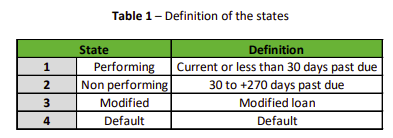

In [61]:
# Copy our data frame before we begin to clean it
dataBureau2 = dataBureau.copy()

# Non-Performing: Since STATUS is strings we'll do an array check. Worse runtime but easy to read
type2 = ['1', '2', '3', '4']
dataBureau2['STATUS'] = dataBureau2['STATUS'].apply(lambda x: 2 if x in type2 else x)

# Performing: Set 0s to 1 just to match our Markov Model charts
type1 = ['0']
dataBureau2['STATUS'] = dataBureau2['STATUS'].apply(lambda x: 1 if x in type1 else x)

# Default
type4 = ['5']
dataBureau2['STATUS'] = dataBureau2['STATUS'].apply(lambda x: 4 if x in type4 else x)

# Other: 'Modified' for now
type3 = ['C', 'X']
dataBureau2['STATUS'] = dataBureau2['STATUS'].apply(lambda x: 3 if x in type3 else x)

# Show that now we have 4 states
print(dataBureau2['STATUS'].value_counts())

3    19457475
1     7499507
2      280537
4       62406
Name: STATUS, dtype: int64


##### Exemplifying Transitions with Cleaned Status Model

In [62]:
# Amount of IDs we wish to see the markovian chains for - usually set to small number to save runtime
numIds = 4

# Determines unique bureau IDs and iterates through desired number, exemplifying Markovian chains
uniqueIds = dataBureau2['SK_ID_BUREAU'].value_counts()
if debug == True:
    print("There are: ", len(uniqueIds), "unique IDs in data bureau")
    print("Printing first",numIds,"variable transitions to exemplify HMM parameters")
    for uniqueId in range(numIds):
        exemplifyTransition(uniqueIds.index[uniqueId], dataBureau2)

There are:  817395 unique IDs in data bureau
Printing first 4 variable transitions to exemplify HMM parameters
ID: 5645521
3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 
 ---------------------------------------------------------------------------------------------------------
ID: 6733619
3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 -> 3 

### HMM
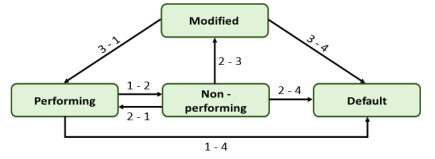

In [63]:
# Obtains a Markov Chain for an ID
def getSeries(idVal, df):
    ret = []
    incr = 0
    for i in df['SK_ID_BUREAU']:
        if i == idVal:
            ret.append(df['STATUS'][incr])
        incr = incr+1
    return ret

##### Determining Node Frequencies

In [64]:
dataBureau2['STATUS'].value_counts()

3    19457475
1     7499507
2      280537
4       62406
Name: STATUS, dtype: int64

##### Engineering HMM State Space

In [65]:
# Define states for our HMM
states = ['Performing', 'Non-Performing', 'Modified', 'Default']

# Define frequency for each state
pi = []
for i in dataBureau2['STATUS'].value_counts():
    pi.append(i/dataBureau2.shape[0])

    
state_space = pd.Series(pi, index=states, name='states')
print(state_space)
print(state_space.sum())

Performing        0.712730
Non-Performing    0.274708
Modified          0.010276
Default           0.002286
Name: states, dtype: float64
0.9999999999999999


##### Create Transition Matrix

In [66]:
# create transition matrix
# equals transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.4, 0.2, 0.2, 0.2]
q_df.loc[states[1]] = [0.4, 0.4, 0.1, .1]
q_df.loc[states[2]] = [0.4, 0.2, .2, .2]
q_df.loc[states[3]] = [0.4, 0.2, .2, .2]

print(q_df)

q = q_df.values
print('\n', q, q.shape, '\n')
print(q_df.sum(axis=1))

               Performing Non-Performing Modified Default
Performing            0.4            0.2      0.2     0.2
Non-Performing        0.4            0.4      0.1     0.1
Modified              0.4            0.2      0.2     0.2
Default               0.4            0.2      0.2     0.2

 [[0.4 0.2 0.2 0.2]
 [0.4 0.4 0.1 0.1]
 [0.4 0.2 0.2 0.2]
 [0.4 0.2 0.2 0.2]] (4, 4) 

Performing        1.0
Non-Performing    1.0
Modified          1.0
Default           1.0
dtype: float64


##### Getting Markov Edges

In [67]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

{('Default', 'Default'): 0.2,
 ('Default', 'Modified'): 0.2,
 ('Default', 'Non-Performing'): 0.2,
 ('Default', 'Performing'): 0.4,
 ('Modified', 'Default'): 0.2,
 ('Modified', 'Modified'): 0.2,
 ('Modified', 'Non-Performing'): 0.2,
 ('Modified', 'Performing'): 0.4,
 ('Non-Performing', 'Default'): 0.1,
 ('Non-Performing', 'Modified'): 0.1,
 ('Non-Performing', 'Non-Performing'): 0.4,
 ('Non-Performing', 'Performing'): 0.4,
 ('Performing', 'Default'): 0.2,
 ('Performing', 'Modified'): 0.2,
 ('Performing', 'Non-Performing'): 0.2,
 ('Performing', 'Performing'): 0.4}


In [68]:
# Left-right HMM
lr = hmm.GaussianHMM(n_components=4, covariance_type="diag",
                     init_params="cm", params="cmt")
lr.fit(getSeries(uniqueIds.index[0], dataBureau2))

NameError: name 'hmm' is not defined

In [ ]:
from hmmlearn.hmm import GaussianHMM
 
def fitHMM(Q, nSamples):
    # fit Gaussian HMM to Q
    #model = GaussianHMM(n_components=4, n_iter=1000).fit(np.reshape(Q,[len(Q),1]))
    model = GaussianHMM(n_components=4, n_iter=1000).fit(np.reshape(Q,[len(Q),1]))
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(np.reshape(Q,[len(Q),1]))
 
    # find parameters of Gaussian HMM
    mus = np.array(model.means_)
    sigmas = np.array(np.sqrt(np.array([np.diag(model.covars_[0]),np.diag(model.covars_[1])])))
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(np.reshape(Q,[len(Q),1]))
 
    # generate nSamples from Gaussian HMM
    samples = model.sample(nSamples)
 
    # re-organize mus, sigmas and P so that first row is lower mean (if not already)
    if mus[0] > mus[1]:
        mus = np.flipud(mus)
        sigmas = np.flipud(sigmas)
        P = np.fliplr(np.flipud(P))
        hidden_states = 1 - hidden_states
 
    return hidden_states, mus, sigmas, P, logProb, samples, model
 
#logQ = getSeries(uniqueIds.index[0], dataBureau2)
#logQ = dataBureau2['STATUS']
#np.reshape(dataBureau2['STATUS'], [len(dataBureau2['STATUS']), 1])
hidden_states, mus, sigmas, P, logProb, samples, model = fitHMM(logQ, 100)

In [ ]:
for i in range(len(uniqueIds.index)):
    currSeries = getSeries(uniqueIds.index[i], dataBureau2)
    hidden_states, mus, sigmas, P, logProb, samples, model = fitHMM(currSeries, 100)
    print(model.predict())
    
#for i in range(len(uniqueIds.index)):
#    print(i)

#logQ = getSeries(uniqueIds.index[0], dataBureau2)


In [ ]:
Z2 = model.predict(np.reshape(logQ, [len(logQ),1]))
Z2

In [ ]:
# Import hmm libraries
import numpy as np
from hmmlearn import hmm
np.random.seed(42)

# Create HMM
model = hmm.GaussianHMM(n_components = 4, covariance_type = "full")
model.startprob_ = np.array([.5,.5,.5,.5])
model.transmat_ = np.array([[.5,.5,.5]
                            [.5,.5,.5],
                            [.5,.5,.5]])


In [ ]:
import numpy as np
from hmmlearn import hmm
np.random.seed(42)

# Create HMM
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(100)

In [ ]:
# Left-right HMM
lr = hmm.GaussianHMM(n_components=3, covariance_type="diag",
                     init_params="cm", params="cmt")
lr.startprob_ = np.array([1.0, 0.0, 0.0])
lr.transmat_ = np.array([[0.5, 0.5, 0.0],
                         [0.0, 0.5, 0.5],
                         [0.0, 0.0, 1.0]])

In [ ]:
model = hmm.GaussianHMM(n_components=3, n_iter=100, init_params="mcs")
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])

In [ ]:
model.fit(X)

In [ ]:
Z2 = model.predict(X)
Z2